In [1]:
#%%
import os
import FinanceDataReader as fdr
from bt.algos import RunDaily
from pypfopt.expected_returns import prices_from_returns
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs
import seaborn as sns
import sys

pd.options.display.float_format = '{:.4f}'.format
plt.style.use('default') #ggplot
plt.rcParams['font.family'] = 'nanummyeongjo'
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.formatter.useoffset'] = False
# plt.rcParmas['axes.formatter.limits'] = -1000, 1000

plt.rcParams['axes.unicode_minus'] = False

from IPython.display import display, HTML

# sys.path.insert(0, "/Users/hosung/workspace/git/bt/")
# for p in sys.path:
#     print(p)
%matplotlib inline

import bt
bt.__version__

(0, 2, 9)

In [2]:
def long_only_ew(data, tickers, start_date, name='long_only_ew', initial_capital=1000000.0):
    s = bt.Strategy(name,
    [
        bt.algos.RunAfterDate(start_date),
        bt.algos.RunOnce(),
        bt.algos.SelectThese(tickers),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()
    ])
    return bt.Backtest(s, data, initial_capital=initial_capital)

In [3]:
df = pd.read_csv('asset_db.csv', index_col=0, parse_dates=True)

In [4]:
cols = ['nasdaq100_UH', 'kbond20y', 'kodex200x2', 'usdkrwx2']
price_df = df[cols].copy()
#nasdaq100_UH 1985-10-02 00:00:00
#kbond20y 1981-05-01 00:00:00
#kodex200x2 1981-05-01 00:00:00
#usdkrwx2 1981-05-01 00:00:00


In [5]:
price_df['1985-10'].tail(2)

/var/folders/68/pm9snk_d53j26rdq0n4v_jn80000gn/T/ipykernel_77873/572385914.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  price_df['1985-10'].tail(2)


,nasdaq100_UH,kbond20y,kodex200x2,usdkrwx2
Date,,,,
1985-10-30,443.9889,819.4888,527.9910,4753.0506
1985-10-31,442.7283,821.6153,520.8193,4750.2029


In [6]:
price_df['1986-10'].tail(2)

/var/folders/68/pm9snk_d53j26rdq0n4v_jn80000gn/T/ipykernel_77873/779653957.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  price_df['1986-10'].tail(2)


,nasdaq100_UH,kbond20y,kodex200x2,usdkrwx2
Date,,,,
1986-10-30,544.2618,981.1386,1454.1757,4662.7489
1986-10-31,543.1959,979.4770,1457.7345,4664.1452


In [7]:
price_df.tail(2)

,nasdaq100_UH,kbond20y,kodex200x2,usdkrwx2
Date,,,,
2021-09-30,78930.0000,126480.0000,24560.0000,10105.0000
2021-10-01,77670.0000,125820.0000,23610.0000,10170.0000


In [8]:
start_date = '1986-10-30'
price_df = price_df.dropna()['1985-10-30':]

In [9]:
def strategy_aibeta(price_df, lookback=3, max=0.5):
    st = bt.Strategy(f"AIBeta_{lookback}_{max:.2f}",
                    [
                        bt.algos.RunAfterDate(start_date),
                        bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=True),
                        # bt.algos.PrintDate(),
                        bt.algos.SelectAll(),
                        bt.algos.WeighMeanVar(lookback=pd.DateOffset(months=lookback), lag = pd.DateOffset(days=1),
                                            bounds=(0.0, max), covar_method='standard'),
                        bt.algos.Rebalance()
                    ])
    bt_ai_beta = bt.Backtest(st, price_df)
    return bt_ai_beta

In [32]:
test_aibeta = {}
for lookback in range(3, 13):
    # print(f"lookback : {lookback}")
    for bound in np.arange(0.3, 0.5, 0.05):
        test_aibeta[f'AIBeta_{lookback}_{bound:.2f}'] = strategy_aibeta(price_df, lookback, bound)
# %%
rm = bt.run(*test_aibeta.values())

/Users/hosung/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [33]:
stats = rm.prices[start_date:].calc_stats().stats
stats

,AIBeta_3_0.30,AIBeta_3_0.35,AIBeta_3_0.40,AIBeta_3_0.45,AIBeta_4_0.30,AIBeta_4_0.35,AIBeta_4_0.40,AIBeta_4_0.45,AIBeta_5_0.30,AIBeta_5_0.35,...,AIBeta_10_0.40,AIBeta_10_0.45,AIBeta_11_0.30,AIBeta_11_0.35,AIBeta_11_0.40,AIBeta_11_0.45,AIBeta_12_0.30,AIBeta_12_0.35,AIBeta_12_0.40,AIBeta_12_0.45
start,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,...,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00
end,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,...,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00
rf,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
total_return,239.3039,389.0847,391.5365,398.3324,181.1771,255.2935,225.9471,245.0356,163.4364,221.7018,...,303.5775,299.1875,223.8535,338.1810,312.2821,318.1857,195.1930,283.0574,266.4504,268.1948
cagr,0.1700,0.1863,0.1865,0.1871,0.1607,0.1721,0.1681,0.1708,0.1573,0.1674,...,0.1779,0.1774,0.1677,0.1816,0.1789,0.1795,0.1632,0.1756,0.1736,0.1738
max_drawdown,-0.2836,-0.3481,-0.3515,-0.3626,-0.3822,-0.4625,-0.4307,-0.4288,-0.3868,-0.4609,...,-0.3885,-0.4075,-0.2838,-0.3661,-0.3976,-0.4156,-0.2837,-0.3674,-0.4050,-0.4194
calmar,0.5994,0.5353,0.5307,0.5160,0.4205,0.3722,0.3902,0.3983,0.4067,0.3633,...,0.4581,0.4355,0.5911,0.4959,0.4499,0.4320,0.5752,0.4779,0.4285,0.4143
mtd,-0.0083,-0.0049,-0.0049,-0.0048,-0.0083,-0.0065,-0.0064,-0.0061,-0.0083,-0.0063,...,-0.0102,-0.0093,-0.0137,-0.0131,-0.0119,-0.0108,-0.0150,-0.0149,-0.0130,-0.0118
three_month,-0.0040,-0.0063,-0.0043,-0.0028,-0.0013,0.0062,0.0107,0.0143,-0.0030,0.0003,...,-0.0122,-0.0125,-0.0246,-0.0241,-0.0222,-0.0260,-0.0182,-0.0186,-0.0204,-0.0189
six_month,0.0475,0.0505,0.0475,0.0443,0.0537,0.0637,0.0605,0.0622,0.0509,0.0557,...,0.0438,0.0456,0.0285,0.0313,0.0301,0.0268,0.0355,0.0407,0.0354,0.0373


In [35]:
stats.to_csv('AIBeta_results_extend.csv')

In [36]:
stats = stats.loc[['total_return', 'cagr', 'max_drawdown', 'daily_sharpe'],:].T
stats.columns = ['return', 'cagr', 'mdd', 'sharpe']
stats['mdd'] = stats['mdd']*-1
stats.sort_values(by='return', ascending=False)

,return,cagr,mdd,sharpe
AIBeta_3_0.45,398.3324,0.1871,0.3626,1.0480
AIBeta_3_0.40,391.5365,0.1865,0.3515,1.0835
AIBeta_3_0.35,389.0847,0.1863,0.3481,1.1022
AIBeta_11_0.35,338.1810,0.1816,0.3661,1.0815
AIBeta_10_0.35,328.3444,0.1806,0.3483,1.0768
AIBeta_11_0.45,318.1857,0.1795,0.4156,1.0220
AIBeta_11_0.40,312.2821,0.1789,0.3976,1.0492
AIBeta_10_0.40,303.5775,0.1779,0.3885,1.0423
AIBeta_6_0.45,302.1959,0.1778,0.4360,0.9814
AIBeta_10_0.45,299.1875,0.1774,0.4075,1.0086


<AxesSubplot:>

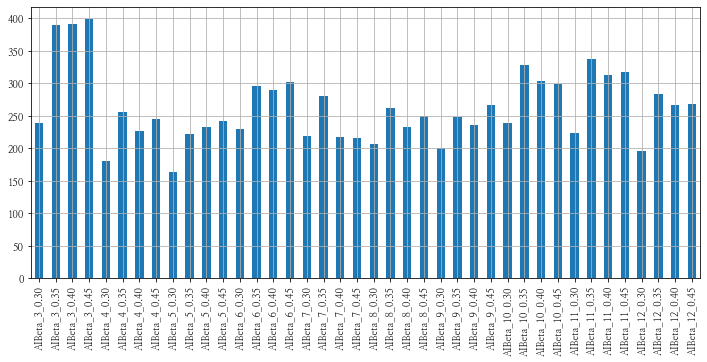

In [37]:
stats['return'].plot.bar(figsize=(12, 5))#, secondary_y=['mdd'])

<AxesSubplot:>

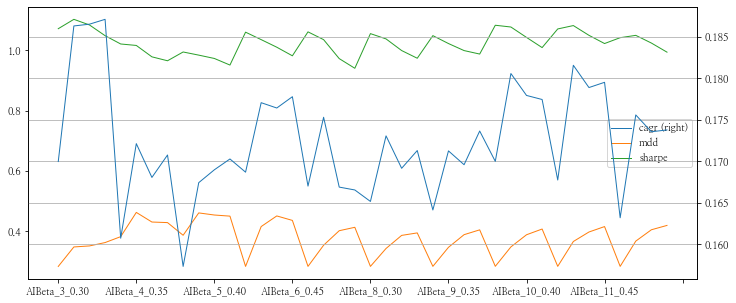

In [38]:
stats[['cagr', 'mdd', 'sharpe']].plot(figsize=(12,5), secondary_y=['cagr'])

In [39]:
bt_ew = long_only_ew(price_df, cols, start_date, "ew")

bt_kodex200x2 = long_only_ew(price_df, ["kodex200x2"], start_date, "kodex200x2")
bt_kbond20y = long_only_ew(price_df, ["kbond20y"], start_date, "kbond20y")
bt_nasdaq100_UH = long_only_ew(price_df, ["nasdaq100_UH"], start_date, "nasdaq100_UH")
bt_usdkrwx2 = long_only_ew(price_df, ["usdkrwx2"], start_date, "usdkrwx2")

bt_ai_beta_35 = strategy_aibeta(price_df, 3, 0.35)
bt_ai_beta_50 = strategy_aibeta(price_df, 3, 0.50)

In [40]:
r = bt.run(bt_ai_beta_35, bt_ai_beta_50, bt_kodex200x2, bt_kbond20y, bt_nasdaq100_UH, bt_usdkrwx2)

In [41]:
r.set_date_range(start=start_date)
r.display()

Stat                 AIBeta_3_0.35    AIBeta_3_0.50    kodex200x2    kbond20y    nasdaq100_UH    usdkrwx2
-------------------  ---------------  ---------------  ------------  ----------  --------------  ----------
Start                1986-10-30       1986-10-30       1986-10-30    1986-10-30  1986-10-30      1986-10-30
End                  2021-10-01       2021-10-01       2021-10-01    2021-10-01  2021-10-01      2021-10-01
Risk-free rate       0.00%            0.00%            0.00%         0.00%       0.00%           0.00%

Total Return         38908.47%        42104.94%        1517.43%      12733.73%   14191.33%       117.83%
Daily Sharpe         1.10             1.01             0.40          1.24        0.64            0.21
Daily Sortino        1.80             1.62             0.66          1.87        1.05            0.33
CAGR                 18.63%           18.90%           8.30%         14.91%      15.27%          2.25%
Max Drawdown         -34.81%          -36.84%         

/Users/hosung/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1389: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


<AxesSubplot:>

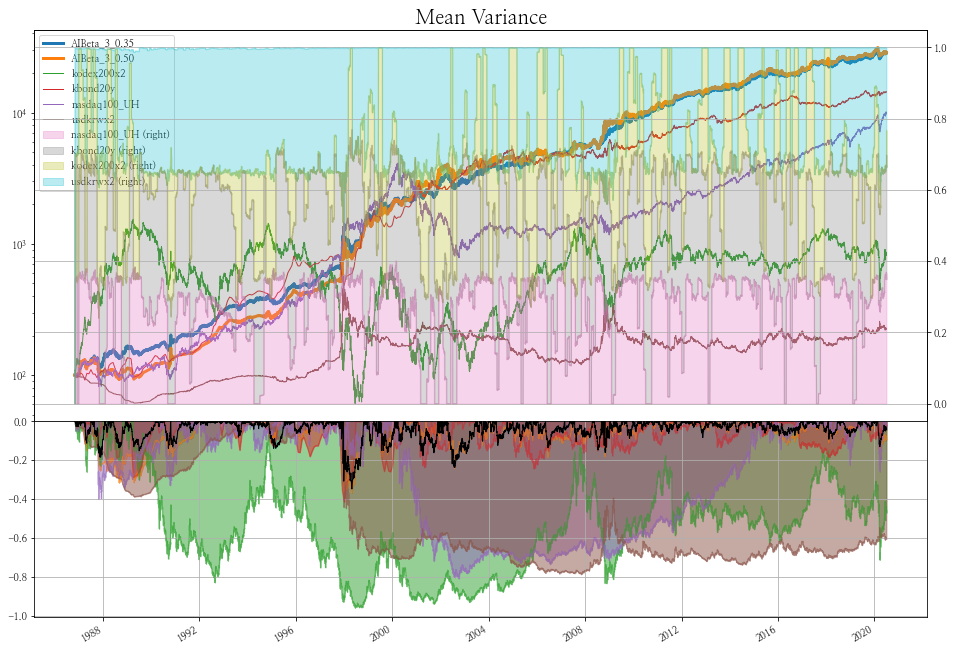

In [42]:
res1 = r
start = start_date
end = '2020-06-30'
plt.rcParams["figure.figsize"] = [16, 12]
plt.subplots_adjust(hspace=0)

# 첫번째 칸에 그림을 그린다.
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
# 두개를 한 칸에 그리기 위해 ax=ax1으로 axis공유
ax2 = res1.prices[start:end].plot(ax=ax1, style=['-', '-', '-', '-', '-', '-', '-'], lw=1, logy=True) # 모든 데이터 r_all
for line in ax2.get_lines():
    if line.get_label() == 'AIBeta_3_0.35' or line.get_label() == 'AIBeta_3_0.50' or line.get_label() == 'AIBet_InvVol':
        line.set_linewidth(3)
plt.legend(loc="upper left");
plt.title('Mean Variance', fontsize=20)
res1.get_security_weights('AIBeta_3_0.35')[start:end].plot.area(alpha=0.3, ax=ax1, secondary_y=True)


# 두번째 칸에 그림을 그린다.
# drawdown을 그림다. 두개를 하나에 그리기 위해 ax=ax2로 axis를 공유
ax2 = plt.subplot2grid((3,1), (2,0))
res1.prices[start:end].to_drawdown_series().plot.area(stacked=False,legend=False, ax=ax2)
res1.prices.loc[start:end,'AIBeta_3_0.35'].to_drawdown_series().plot(legend=False, color='black', alpha=1, lw=1, ls='-', ax=ax2)


In [43]:
r.display_monthly_returns('AIBeta_3_0.35')

  Year    Jan    Feb     Mar    Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec    YTD
------  -----  -----  ------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
  1986   0      0       0      0      0      0      0      0      0     -0     -1.02   2.19   1.14
  1987  16.38   5.97    4.09  -9.35   5.08   6.27   1.17   0.52  -1.97  -7.03  -3.25   7.41  25.18
  1988  14.19  -4.75    8.46   0.5    2.93  -3.26  -2.78  -7.5    2.63   5.83   3.73   8.11  29.3
  1989  -0.86   0.66   -7.09  -2.23   1.97  -6.27   2.73   4.31   1.24   0.77   1.56   0.66  -3.17
  1990   1.59   2.89    0.96  -1.72   5.24   2.25  -1.07  -6.71  -2.11  11.49   1.09   1     14.79
  1991   3.6    3.69    1.65   0.83   0.89  -1.62   2.4   -1.21   1.63   2.7    0.49   4.5   21.18
  1992   5.47   2.25   -0.39   0.36   2.26   1.57   6.04   0.26   5.01   6.57   0.46   3.21  38.13
  1993   3.86   2.31    3.69  -0.74   1.71  -1.29  -2.44  -3.11   6.5    1.4    1.52   2.88  17.06
  1994   3.

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               1986-10-31  1986-10-31
End Period                 2021-10-01  2021-10-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          38,908.47%  42,104.94%
CAGR﹪                     18.62%      18.89%

Sharpe                     1.1         1.01
Smart Sharpe               1.02        0.93
Sortino                    1.65        1.52
Smart Sortino              1.52        1.41
Sortino/√2                 1.17        1.08
Smart Sortino/√2           1.08        0.99
Omega                      1.26        1.26

Max Drawdown               -34.81%     -36.84%
Longest DD Days            483         1154
Volatility (ann.)          16.03%      18.03%
R^2                        0.86        0.86
Calmar                     0.53        0.51
Skew                       -0.1        0.29
Kurtosis                   67.41   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,1997-12-24,1998-04-28,1998-10-30,310,-34.8084,-33.3040
2,2002-04-19,2002-08-05,2003-06-18,425,-23.6992,-22.8659
3,1997-12-12,1997-12-16,1997-12-23,11,-21.7720,-18.5718
4,1987-08-22,1987-11-16,1988-01-27,158,-18.5060,-18.3013
5,2001-01-26,2001-04-10,2001-11-23,301,-17.6543,-16.2750


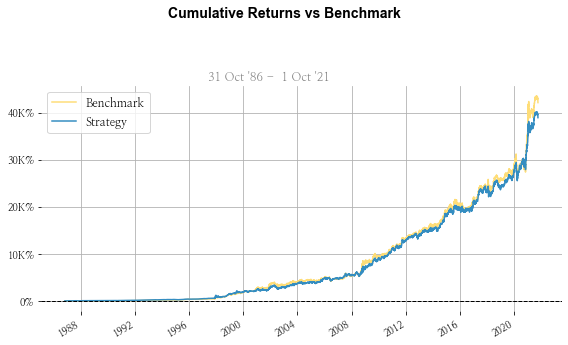

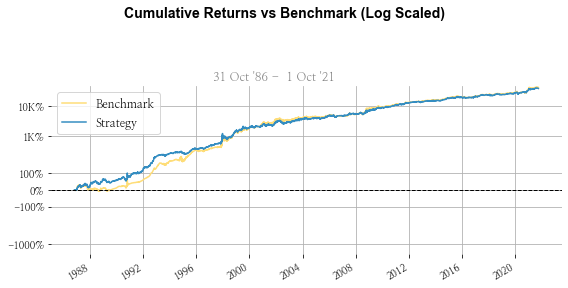

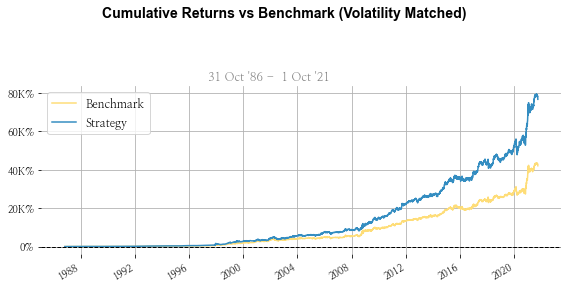

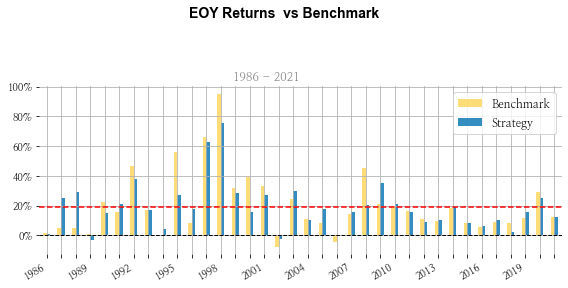

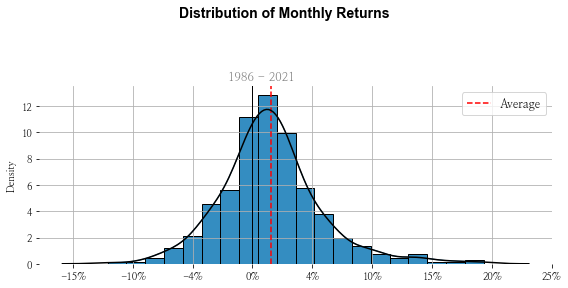

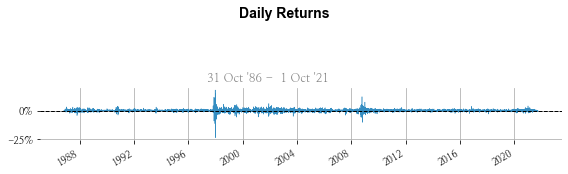

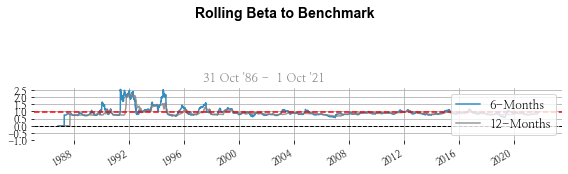

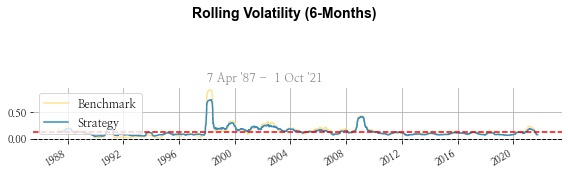

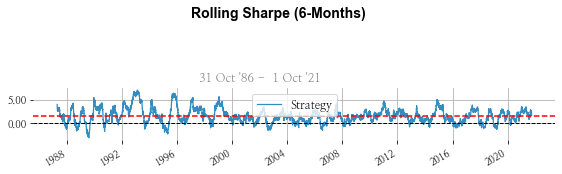

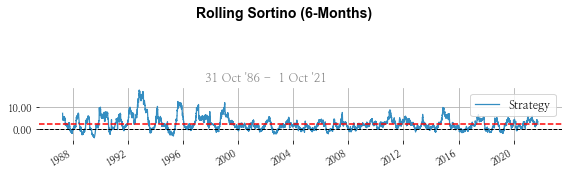

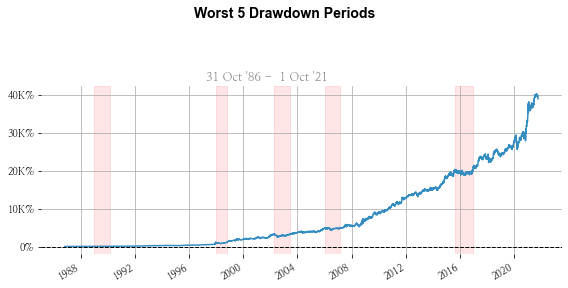

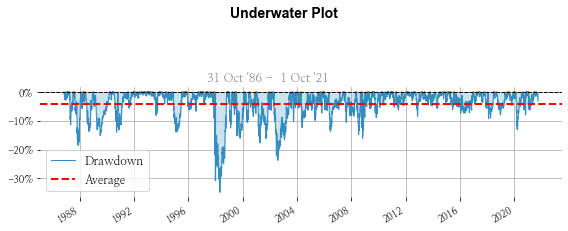

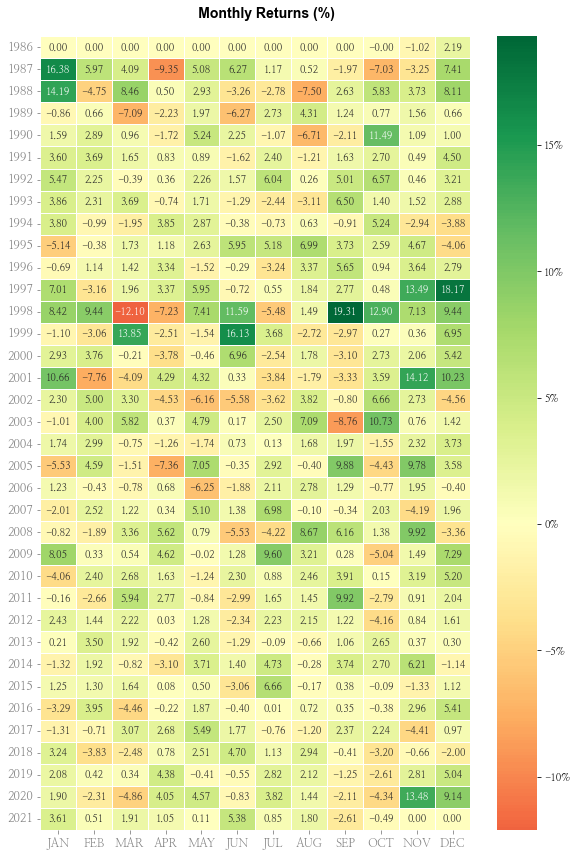

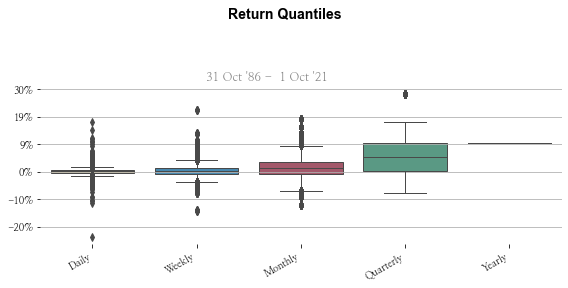

In [44]:
qs.reports.full(r.prices['AIBeta_3_0.35'].to_returns().dropna(), r.prices['AIBeta_3_0.50'].to_returns().dropna())

In [45]:
r.prices.calc_cagr()

AIBeta_3_0.35   0.1863
AIBeta_3_0.50   0.1890
kodex200x2      0.0830
kbond20y        0.1491
nasdaq100_UH    0.1527
usdkrwx2        0.0225
dtype: float64

2021-10-01 00:00:00


<AxesSubplot:>

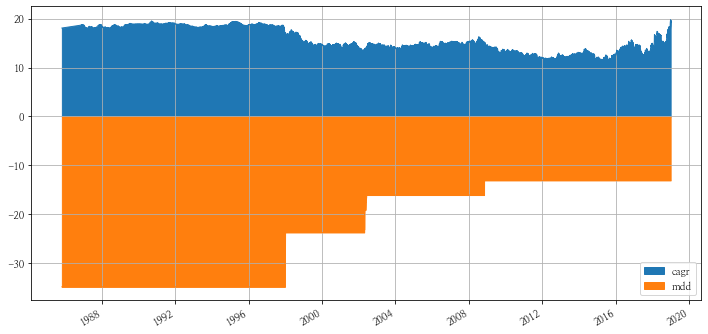

In [46]:
r_ai = bt.run(bt_ai_beta_35)
cagrs = {}
mdds = {}
# for m in pd.date_range(start_date, '2021-10', freq='M'):
for m in r_ai.prices.index:
    # print(m)
    try:
        cagrs[m] = r_ai.prices[m:].calc_cagr().values[0]
        mdds[m] = r_ai.prices[m:].calc_max_drawdown().values[0]
    except:
        print(m)

cagr_df = pd.DataFrame([cagrs]).T*100
mdd_df = pd.DataFrame([mdds]).T*100

tdf = bt.merge(cagr_df, mdd_df)
tdf.columns = ['cagr', 'mdd']

tdf[:'2018'].plot.area(figsize=(12,6))

In [47]:
tdf.to_csv("AIBeta_3개월_0.35_CAGR_MDD.csv")

2021-10-01 00:00:00


<AxesSubplot:>

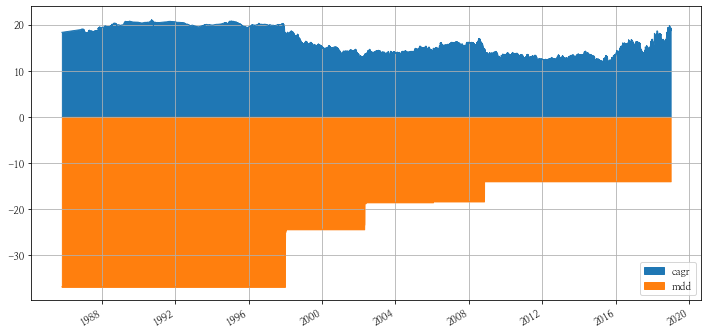

In [48]:
r_ai = bt.run(bt_ai_beta_50)
cagrs = {}
mdds = {}
# for m in pd.date_range(start_date, '2021-10', freq='M'):
for m in r_ai.prices.index:
    # print(m)
    try:
        cagrs[m] = r_ai.prices[m:].calc_cagr().values[0]
        mdds[m] = r_ai.prices[m:].calc_max_drawdown().values[0]
    except:
        print(m)

cagr_df = pd.DataFrame([cagrs]).T*100
mdd_df = pd.DataFrame([mdds]).T*100

tdf = bt.merge(cagr_df, mdd_df)
tdf.columns = ['cagr', 'mdd']

tdf[:'2018'].plot.area(figsize=(12,6))

In [49]:
tdf.to_csv("AIBeta_3개월_0.50_CAGR_MDD.csv")

(0.0, 1.0)

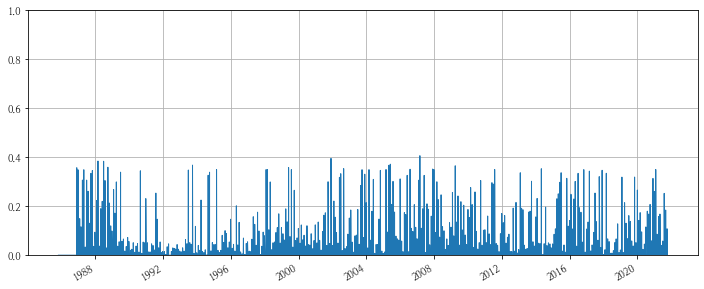

In [50]:
ax = bt_ai_beta_35.turnover.plot(figsize=(12,5))
ax.set_ylim(0.0, 1.0)

(0.0, 1.0)

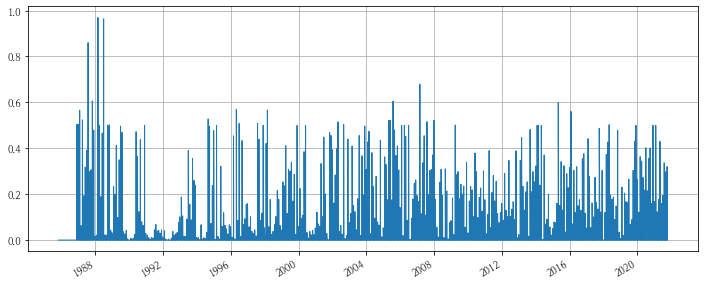

In [51]:
bt_ai_beta_50.turnover.plot(figsize=(12,5))
ax.set_ylim(0.0, 1.0)